<a href="https://colab.research.google.com/github/xbaca8/2021-CAM-REU/blob/main/Hyperspectral_SSL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -q graphlearning

     |████████████████████████████████| 49 kB 6.8 MB/s 
     |████████████████████████████████| 646 kB 46.4 MB/s 
     |████████████████████████████████| 93 kB 902 kB/s 


In [ ]:
pip install -U numpy

In [ ]:
import matplotlib.pyplot as plt
import urllib.request
import graphlearning as gl
from scipy.io import loadmat
import numpy as np
import scipy.spatial as spatial
import scipy.sparse as sparse
import os

In [ ]:
def importH_image(url, file_name, key_name, subsample = False, display_slice = False):
    """
    Loads in image from the internet
    importH_image takes in:
        url: Pathway to image on internet
        file_name: Name of file on internet
        subsample: Whether or not to subsample the image. default to False
        display_slice - Whether or not to show a slice of one of the
                        Hyperspectral bands
    """
    urllib.request.urlretrieve(url, file_name)
    data = loadmat(file_name)
    image = data[key_name]
    image = image.astype('float32')

    #Scale pixel values to [0,1]
    image = image/255

    if subsample:
        #Subsample the image
        image = image[::2,::2,:]

    #Print image shape
    print(image.shape)

    #Display image
    if display_slice:
        rand_slice = np.random.randint(image.shape[2])
        plt.imshow(image[:,:,rand_slice])
        plt.show(block = True)
        print(rand_slice)
          
    return image    

In [ ]:
def importH_GT(url, file_name, key_name):
  # Get ground truth labels
  urllib.request.urlretrieve(url, file_name)
  data = loadmat(file_name)
  gt = data[key_name]
  return gt

In [ ]:
#Download image
image = importH_image('http://www.ehu.eus/ccwintco/uploads/d/df/SalinasA.mat', 'salinasA.mat', 'salinasA')

salinas2d = image.reshape(-1, image.shape[2])
knn = 30

try:
    print("Looking for precomputed weight matrix ...")
    # W = gl.knn_weight_matrix(knn, dataset='salinasA', metric='angular')
    I,J,D = gl.load_kNN_data('salinasA', metric='angular')
except:
    print("Error in finding weight matrix, computing from scratch")
    I,J,D = gl.knnsearch_annoy(salinas2d, k=knn, similarity='angular', dataset='salinasA', metric='angular')
W = gl.weight_matrix(I,J,D,knn)

(83, 86, 224)
Looking for precomputed weight matrix ...
Error in finding weight matrix, computing from scratch
kNN search with Annoy approximate nearest neighbor package...
Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [ ]:
"""Let's compute and plot the eigenvectors now."""

L = gl.graph_laplacian(W, norm='normalized')

num_eigenvectors = 10
vals, vecs = sparse.linalg.eigs(L,k=num_eigenvectors,which='SM')

for i in range(1, num_eigenvectors):
  selected_eigenvector = vecs[:,i].real
  reshapedeigen = selected_eigenvector.reshape(83, 86)
  plt.imshow(reshapedeigen,cmap='gray', vmin = np.min(selected_eigenvector), vmax = np.max(selected_eigenvector))
  plt.title("Eigenvector " + str(i))
  plt.show(block = True)

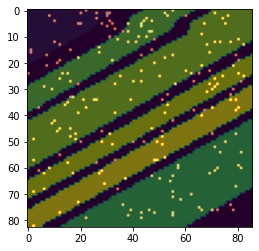

In [ ]:
gt = importH_GT('http://www.ehu.eus/ccwintco/uploads/a/aa/SalinasA_gt.mat', 'salinasA_gt.mat', 'salinasA_gt')
#define small subset of labeled data (randomly)
labels = gt.flatten().astype(int)
map = np.arange(15)
map[10:15] = np.arange(2,7)
labels = map[labels]  

num_train_per_class = 30
train_ind = gl.randomize_labels(labels, num_train_per_class)
train_labels = labels[train_ind]

# Create blank array of zeros same size as original image
overlay_array = np.zeros((gt.shape[0], gt.shape[1]), dtype = int)

# For loop that makes overlay array entries 1 where a label is taken from
for i in range(len(train_ind)):
    y_loc = train_ind[i] // gt.shape[1]
    x_loc = train_ind[i] % gt.shape[0]

    overlay_array[y_loc, x_loc] = 1

plt.imshow(gt)
plt.imshow(overlay_array, cmap = 'afmhot', alpha = 0.5)

In [ ]:
from sklearn.feature_extraction.image import extract_patches_2d
from scipy.ndimage import gaussian_filter
from sklearn.cluster import KMeans

## Function for Non-Local Means Method
def NonLocalMeans(image, d):
  
  ## Pad the image with mirror reflections of itself with a width d
  pad = (d,d)
  padimage = np.pad(image,(pad,pad,(0,0)),mode='reflect') #(top,bottom),(left,right),(0,0)

  ## For the ith pixel, make a (2d + 1) by (2d + 1) patch centered at pixel i
  patches = extract_patches_2d(padimage, (2*d+1,2*d+1))

  ## For the jth, (j = 1; 2; 3) band, apply a Gaussian kernel on this patch
  u = np.zeros((2*d+1,2*d+1))
  u[d,d] = 1
  G = gaussian_filter(u,d/2,mode='constant',cval=0)
  #patches = patches * G[np.newaxis,:,:,np.newaxis]
  ## Form the feature matrix F by letting each row of F be a feature vector of a pixel
  F = patches.reshape((patches.shape[0],patches.shape[3], patches.shape[1], patches.shape[2]))
  print("feature vector shape: ", F.shape)

  return F

Importing Salinas

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
'''
salinas = importH_image('http://www.ehu.eus/ccwintco/uploads/f/f1/Salinas.mat', 'salinas.mat', 'salinas')
S_labels = importH_GT('http://www.ehu.eus/ccwintco/uploads/f/fa/Salinas_gt.mat', 'salinas_gt.mat', 'salinas_gt')
'''
#define small subset of labeled data (randomly)
S_labels = S_labels.flatten().astype(int)

num_train_per_class = 30
S_train_ind = gl.randomize_labels(S_labels, num_train_per_class)
S_train_labels = S_labels[S_train_ind]

kNN search with Annoy approximate nearest neighbor package...
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Ground Truth:


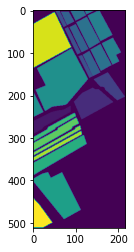

Laplace learning: 53.74%


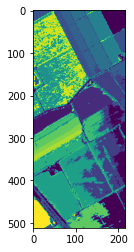

In [ ]:
S_2d = salinas.reshape(-1, salinas.shape[2])

# PCA on Salinas, code from Jason - 10 variables capture 99.96% of data
pca = PCA(n_components=10)
reduced_salinas = pca.fit_transform(S_2d)

knn = 40

I,J,D = gl.knnsearch_annoy(reduced_salinas, k=knn, similarity='angular', dataset='salinas', metric='angular')
W_S = gl.weight_matrix(I,J,D,knn)

# run gbssl (poisson or laplace)
#Run Laplace learning
S_labels_laplace = gl.graph_ssl(W_S,S_train_ind,S_train_labels,algorithm='laplace')

# compare results -- compute accuracy 
print('Ground Truth:')
showGT = S_labels.reshape(512,217)
plt.imshow(showGT)
plt.show(block = True)

print('Laplace learning: %.2f%%'%gl.accuracy(S_labels,S_labels_laplace,len(S_train_ind)))
showLaplace = S_labels_laplace.reshape(512, 217)
plt.imshow(showLaplace)
plt.show(block = True)


In [ ]:
# PCA on Salinas, code from Jason - 10 variables capture 99.96% of data
pca = PCA(n_components=10)
num_pixels = salinas.shape[0]*salinas.shape[1]
reduced_salinas = pca.fit_transform(salinas.reshape(num_pixels, salinas.shape[2]))
reduced_salinas = reduced_salinas.reshape(salinas.shape[0], salinas.shape[1], 10)

#Load Salinas data into (7138, 10, 9, 9) shape
S_data = NonLocalMeans(reduced_salinas, 4)

#Splitting data into training and testing
train_data, test_data, train_labels, test_labels = train_test_split(S_data, S_labels, test_size = 0.3)


feature vector shape:  (111104, 10, 9, 9)


Simple Graph Learning on Salinas-A

Laplace learning: 75.74%


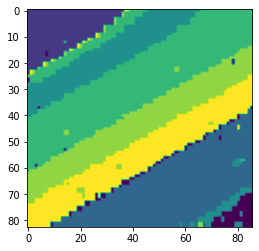

Poisson learning: 60.58%


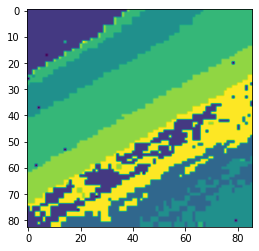

In [ ]:
# run gbssl (poisson or laplace)
#Run Laplace learning
labels_laplace = gl.graph_ssl(W,train_ind,train_labels,algorithm='laplace')

#Run Poisson learning
labels_poisson = gl.graph_ssl(W,train_ind,train_labels,algorithm='poisson')

# compare results -- compute accuracy 
print('Laplace learning: %.2f%%'%gl.accuracy(labels,labels_laplace,len(train_ind)))
showLaplace = labels_laplace.reshape(83, 86)
plt.imshow(showLaplace)
plt.show(block = True)

print('Poisson learning: %.2f%%'%gl.accuracy(labels,labels_poisson,len(train_ind)))
showPoisson = labels_poisson.reshape(83, 86)
plt.imshow(showPoisson)
plt.show(block = True)



# VAE


In [ ]:
import torch
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(224, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 224)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 224))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 224), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(data_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(data_loader.dataset)))

NameError: ignored

In [ ]:
no_cuda = False
batch_size = 128
log_interval = 10    #how many batches to wait before logging training status
epochs = 100

#GPU settings
cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

#Load SalinasA data
salinas2d = salinas2d/np.max(salinas2d)
data = salinas2d
target = labels

#Convert to torch dataloaders
data = torch.from_numpy(data).float()
target = torch.from_numpy(target).long()
salinasA = MyDataset(data, target) 
data_loader = DataLoader(salinasA, batch_size = batch_size, shuffle = True, **kwargs)

#Put model on GPU and set up optimizer
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

#Training epochs
for epoch in range(1, epochs + 1):
    train(epoch)

#Encode the dataset and save to npz file
with torch.no_grad():
    mu, logvar = model.encode(data.to(device).view(-1, 224))
    Y = mu.cpu().numpy()
    np.savez_compressed('SalinasA_vae.npz',data=Y,labels=target.numpy())

In [ ]:
import graphlearning as gl
import numpy as np

#Load labels, knndata, and build 10-nearest neighbor weight matrix
W_raw = W

#Variational autoencoder weight matrix (can use commented line below, 
#but we're showing how to use the embedding computed above)
#W_vae = gl.knn_weight_matrix(10,dataset='mnist',metric='vae')
M = np.load('SalinasA_vae.npz')
data = M['data']
W_vae = gl.knn_weight_matrix(20,data=data);

#Randomly chose training datapoints (use a stored permutation to be consistent)
#perm = gl.load_label_permutation('mnist')
#train_ind = perm[0]
#train_labels = labels[train_ind]

#Run Laplace and Poisson learning
labels_raw = gl.graph_ssl(W_raw,train_ind,train_labels,algorithm='laplace')
labels_vae = gl.graph_ssl(W_vae,train_ind,train_labels,algorithm='laplace')

#Print accuracy
print('Using %d labels per class'%int(len(train_ind)/7))
print('Accuracy using raw pixel values: %.2f'%gl.accuracy(labels_raw,labels,len(train_ind)))
print('Accuracy using VAE: %.2f'%gl.accuracy(labels_vae,labels,len(train_ind)))

# CNN Try #2

In [ ]:
# Imports
import torch
import torchvision # torch package for vision related things
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import Dataset, DataLoader  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For nice progress bar!
from torch.optim.lr_scheduler import StepLR

# Simple CNN
class CNN(nn.Module):
    def __init__(self, in_channels=in_channels, num_classes=num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=in_channels*9, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=in_channels*9, out_channels=in_channels*36, kernel_size=3, stride=1, padding=1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear((in_channels*36)* 9 * 9, 120)
        self.fc2 = nn.Linear(120, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        #x = self.dropout1(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        x = F.relu(x)
        #x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

    def convnet(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        #x = self.dropout1(x)
        x = x.reshape(x.shape[0], -1)
        return x

class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)

# Train Network
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if dry_run:
                break

# Test Network
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# Check accuracy on training & test to see how good our model
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}")
    model.train()
    #return num_correct/num_samples

Salinas-A version:

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Hyperparameters
in_channels = 10
num_classes = 7
learning_rate = 0.001
batch_size = 32
num_epochs = 20
log_interval = 20
dry_run = False
cuda = True
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

# PCA on Salinas-A, code from Jason - 10 variables capture 99.96% of data
pca = PCA(n_components=10)
num_pixels = image.shape[0]*image.shape[1]
reduced_image = pca.fit_transform(image.reshape(num_pixels, image.shape[2]))
reduced_image = reduced_image.reshape(image.shape[0], image.shape[1], 10)

#Load SalinasA data into (7138, 10, 9, 9) shape
salinas_patches = NonLocalMeans(reduced_image, 4)

#Splitting data into training and testing
train_data, test_data, train_labels, test_labels = train_test_split(salinas_patches, labels, test_size = 0.3)

#Convert to torch dataloaders
train_A_data = torch.from_numpy(train_data).float()
test_A_data = torch.from_numpy(test_data).float()
train_A_labels = torch.from_numpy(train_labels).long()
test_A_labels = torch.from_numpy(test_labels).long()

salinasA_train = MyDataset(train_A_data, train_A_labels) 
train_loader = DataLoader(salinasA_train, batch_size = batch_size, shuffle = True, **kwargs)

salinasA_test = MyDataset(test_A_data, test_A_labels) 
test_loader = DataLoader(salinasA_test, batch_size = batch_size, shuffle = True, **kwargs)

feature vector shape:  (7138, 10, 9, 9)


In [ ]:
#GPU settings
use_cuda = cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Initialize network
model = CNN().to(device)
optimizer = optim.Adadelta(model.parameters(), lr = learning_rate)
scheduler = StepLR(optimizer, step_size=1, gamma = 0.7)

In [ ]:
SA_unrun = torch.from_numpy(salinas_patches).float()
with torch.no_grad():
    Y = model.convnet(SA_unrun.to(device)).cpu().numpy()
    np.savez_compressed('SalinasA_noCNN.npz',data=Y,labels=labels)

In [ ]:
V = np.load('SalinasA_noCNN.npz')
SA_unrun_data = V['data']
labels = V['labels']

#PCA on Salinas-A CNN encoded data
pca = PCA(n_components=150)
num_pixels = SA_unrun_data.shape[0]
X = pca.fit_transform(SA_unrun_data)
print(X.shape)

W_nocnn = gl.knn_weight_matrix(20,data=X, metric = 'angular');

(7138, 150)
kNN search with Annoy approximate nearest neighbor package...
Progress: |██████████████████████████████████████████████████| 100.0% Complete


Using 30 labels per class
Accuracy using raw pixel values: 79.21
Accuracy using no training on CNN: 91.25


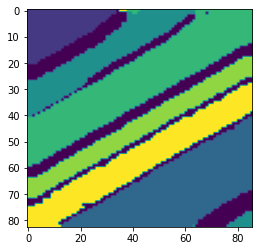

In [ ]:
W_raw = W

#Run Laplace learning
labels_raw = gl.graph_ssl(W_raw,train_ind,train_labels,algorithm='laplace')
labels_nocnn = gl.graph_ssl(W_nocnn,train_ind,train_labels,algorithm='laplace')

#Print accuracy
print('Using %d labels per class'%int(len(train_ind)/7))
print('Accuracy using raw pixel values: %.2f'%gl.accuracy(labels_raw,labels,len(train_ind)))
print('Accuracy using no training on CNN: %.2f'%gl.accuracy(labels_nocnn,labels,len(train_ind)))

# Results
shownoCNN = labels_nocnn.reshape(83, 86)
plt.imshow(shownoCNN)
plt.show(block = True)

In [ ]:
#Main training loop
for epoch in range(1, num_epochs + 1):
  train(model, device, train_loader, optimizer, epoch)
  test(model, device, test_loader)
  scheduler.step()

check_accuracy(train_loader, model)
check_accuracy(test_loader, model)

#Save model
torch.save(model.state_dict(), 'Salinas_cnn.pt')

#Encode the dataset and save to npz file
SA_data = torch.from_numpy(salinas_patches).float()

model.eval()
with torch.no_grad():
    Y = model.convnet(SA_data.to(device)).cpu().numpy()
    np.savez_compressed('SalinasA_cnn.npz',data=Y,labels=labels)

Train Epoch: 1 [0/4996 (0%)]	Loss: 2.001663
Train Epoch: 1 [640/4996 (13%)]	Loss: 1.661288
Train Epoch: 1 [1280/4996 (25%)]	Loss: 1.500719
Train Epoch: 1 [1920/4996 (38%)]	Loss: 1.151530
Train Epoch: 1 [2560/4996 (51%)]	Loss: 1.246095
Train Epoch: 1 [3200/4996 (64%)]	Loss: 1.157336
Train Epoch: 1 [3840/4996 (76%)]	Loss: 0.968842
Train Epoch: 1 [4480/4996 (89%)]	Loss: 0.847587

Test set: Average loss: 0.8171, Accuracy: 1762/2142 (82%)

Train Epoch: 2 [0/4996 (0%)]	Loss: 0.700940
Train Epoch: 2 [640/4996 (13%)]	Loss: 0.721074
Train Epoch: 2 [1280/4996 (25%)]	Loss: 0.634219
Train Epoch: 2 [1920/4996 (38%)]	Loss: 0.752927
Train Epoch: 2 [2560/4996 (51%)]	Loss: 0.616912
Train Epoch: 2 [3200/4996 (64%)]	Loss: 0.565322
Train Epoch: 2 [3840/4996 (76%)]	Loss: 0.611603
Train Epoch: 2 [4480/4996 (89%)]	Loss: 0.678035

Test set: Average loss: 0.5831, Accuracy: 1884/2142 (88%)

Train Epoch: 3 [0/4996 (0%)]	Loss: 0.645629
Train Epoch: 3 [640/4996 (13%)]	Loss: 0.517412
Train Epoch: 3 [1280/4996 (25%)

In [ ]:
#Load labels, knndata, and build 10-nearest neighbor weight matrix
W_raw = W

#Variational autoencoder weight matrix (can use commented line below, 
#but we're showing how to use the embedding computed above)
M = np.load('SalinasA_cnn.npz')
SA_data = M['data']
print(SA_data.shape)
labels = M['labels']

#PCA on Salinas-A CNN encoded data
pca = PCA(n_components=150)
num_pixels = SA_data.shape[0]
reduced_SA = pca.fit_transform(SA_data)
print(reduced_SA.shape)

W_cnn = gl.knn_weight_matrix(20,data=reduced_SA, metric = 'angular');

(7138, 29160)
(7138, 150)
kNN search with Annoy approximate nearest neighbor package...
Progress: |██████████████████████████████████████████████████| 100.0% Complete


Using 30 labels per class
Accuracy using raw pixel values: 79.21
Accuracy using CNN: 91.22


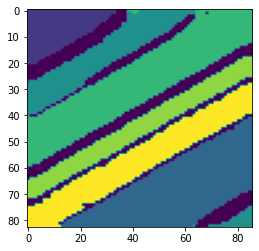

In [ ]:
#Run Laplace learning
labels_raw = gl.graph_ssl(W_raw,train_ind,train_labels,algorithm='laplace')
labels_cnn = gl.graph_ssl(W_cnn,train_ind,train_labels,algorithm='laplace')

#Print accuracy
print('Using %d labels per class'%int(len(train_ind)/7))
print('Accuracy using raw pixel values: %.2f'%gl.accuracy(labels_raw,labels,len(train_ind)))
print('Accuracy using CNN: %.2f'%gl.accuracy(labels_cnn,labels,len(train_ind)))

# Results
showCNN = labels_cnn.reshape(83, 86)
plt.imshow(showCNN)
plt.show(block = True)

Salinas version:

In [ ]:
# Hyperparameters
in_channels = 10
num_classes = 17
learning_rate = 0.001
batch_size = 64
num_epochs = 10
log_interval = 200
dry_run = False
cuda = True
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

In [ ]:
#Convert to torch dataloaders
train_S_data = torch.from_numpy(train_data).float()
test_S_data = torch.from_numpy(test_data).float()
train_S_labels = torch.from_numpy(train_labels).long()
test_S_labels = torch.from_numpy(test_labels).long()

salinas_train = MyDataset(train_S_data, train_S_labels) 
train_loader = DataLoader(salinas_train, batch_size = batch_size, shuffle = True, **kwargs)

salinas_test = MyDataset(test_S_data, test_S_labels) 
test_loader = DataLoader(salinas_test, batch_size = batch_size, shuffle = True, **kwargs)

In [ ]:
#GPU settings
use_cuda = cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Initialize network
model = CNN().to(device)
optimizer = optim.Adadelta(model.parameters(), lr = learning_rate)
scheduler = StepLR(optimizer, step_size=1, gamma = 0.7)

In [ ]:
#Main training loop
for epoch in range(1, num_epochs + 1):
  train(model, device, train_loader, optimizer, epoch)
  test(model, device, test_loader)
  scheduler.step()

check_accuracy(train_loader, model)
check_accuracy(test_loader, model)

#Save model
torch.save(model.state_dict(), 'Salinas_cnn.pt')

In [ ]:
#Save encoded data
convData = torch.from_numpy(S_data).float()

S_data = model.convnet(convData.to(device))

W_Scnn = gl.knn_weight_matrix(20,data=S_data, metric = 'angular');
labels_Scnn = gl.graph_ssl(W_Scnn,train_ind,train_labels,algorithm='laplace')

In [ ]:
print('Using %d labels per class'%int(len(train_ind)/17))
print('Accuracy using CNN: %.2f'%gl.accuracy(labels_cnn,labels,len(train_ind)))

# Results
showSCNN = labels_Scnn.reshape(512, 217)
plt.imshow(showSCNN)
plt.show(block = True)

# CNN VAE

In [ ]:
# Imports
import torch
import torchvision # torch package for vision related things
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import Dataset, DataLoader  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For nice progress bar!
from torch.optim.lr_scheduler import StepLR

In [ ]:
import imageio
import matplotlib
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from torchvision.utils import make_grid

matplotlib.style.use('ggplot')

to_pil_image = transforms.ToPILImage()

def image_to_vid(images):
    imgs = [np.array(to_pil_image(img)) for img in images]
    imageio.mimsave('generated_images.gif', imgs)
    
def save_reconstructed_images(recon_images, epoch):
    save_image(recon_images.cpu(), f"output{epoch}.jpg")

def save_loss_plot(train_loss, valid_loss):
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', label='train loss')
    plt.plot(valid_loss, color='red', label='validataion loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss.jpg')
    plt.show()

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)

# Loss function (POTENTIALLY CHANGE BCE TO NLL)
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Training function
def train(model, dataloader, dataset, device, optimizer, criterion):
    model.train()
    running_loss = 0.0
    counter = 0
    for i, (data, _) in enumerate(dataloader):
        counter += 1
        data = data.to(device)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()

    train_loss = running_loss / counter 
    return train_loss

# Validation function
def validate(model, dataloader, dataset, device, criterion):
    model.eval()
    running_loss = 0.0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
            counter += 1
            data= data[0]
            data = data.to(device)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
        
            # save the last batch input and output of every epoch
            if i == int(len(dataset)/dataloader.batch_size) - 1:
                recon_images = reconstruction

    val_loss = running_loss / counter
    return val_loss, recon_images

In [ ]:
kernel_size = 3 # (3, 3) kernel
init_channels = 40 # initial number of filters
image_channels = 10 # Salinas w/ PCA has 10 channels
latent_dim = 32 # latent dimension for sampling

# define a Conv VAE
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()
 
        # encoder
        self.enc1 = nn.Conv2d(
            in_channels=image_channels, out_channels=init_channels, kernel_size=kernel_size, 
            stride=1, padding=1
        )
        self.enc2 = nn.Conv2d(
            in_channels=init_channels, out_channels=init_channels*2, kernel_size=kernel_size, 
            stride=1, padding=1
        )
        self.enc3 = nn.Conv2d(
            in_channels=init_channels*2, out_channels=init_channels*4, kernel_size=kernel_size, 
            stride=1, padding=1
        )
        self.enc4 = nn.Conv2d(
            in_channels=init_channels*4, out_channels=init_channels*8, kernel_size=kernel_size, 
            stride=1, padding=1
        )
        self.dropout1 = nn.Dropout(0.25)
        # fully connected layers for learning representations
        self.fc1 = nn.Linear((init_channels*8)*9*9, 480)
        self.fc_mu = nn.Linear(480, latent_dim)
        self.fc_log_var = nn.Linear(480, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 480)
        # decoder 
        self.dec1 = nn.ConvTranspose2d(
            in_channels=480, out_channels=init_channels*8, kernel_size=kernel_size, 
            stride=1, padding=0
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=init_channels*8, out_channels=init_channels*4, kernel_size=kernel_size, 
            stride=1, padding=0
        )
        self.dec3 = nn.ConvTranspose2d(
            in_channels=init_channels*4, out_channels=init_channels*2, kernel_size=kernel_size, 
            stride=1, padding=0
        )
        self.dec4 = nn.ConvTranspose2d(
            in_channels=init_channels*2, out_channels=image_channels, kernel_size=kernel_size, 
            stride=1, padding=0
        )
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample
 
    def forward(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = x.reshape(x.shape[0], -1)
        hidden = self.fc1(x)
        # get `mu` and `log_var`
        mu = self.fc_mu(hidden)
        log_var = self.fc_log_var(hidden)

        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        z = self.fc2(z)
        z = z.reshape(-1, 480, 1, 1)
 
        # decoding
        x = F.relu(self.dec1(z))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        reconstruction = torch.sigmoid(self.dec4(x))
        return reconstruction, mu, log_var

    def encode1(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = self.dropout1(x)
        x = x.reshape(x.shape[0], -1)
        return x


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Hyperparameters
num_classes = 7
learning_rate = 0.001
batch_size = 64
num_epochs = 3
log_interval = 20
dry_run = False
cuda = False
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
criterion = nn.BCELoss(reduction='sum')

# PCA on Salinas, code from Jason - 10 variables capture 99.96% of data
pca = PCA(n_components=10)
num_pixels = image.shape[0]*image.shape[1]
reduced_image = pca.fit_transform(image.reshape(num_pixels, image.shape[2]))
reduced_image = reduced_image.reshape(image.shape[0], image.shape[1], 10)

#Load SalinasA data into (7138, 10, 9, 9) shape
salinas_patches = NonLocalMeans(reduced_image, 4)
#Normalize data values
salinas_patches = salinas_patches/np.max(salinas_patches)
#salinas_patches = (salinas_patches * 255).astype(np.uint8)

#Splitting data into training and testing
trainData, testData, trainLabels, testLabels = train_test_split(salinas_patches, labels, test_size = 0.3)

#Convert to torch dataloaders
trainData = torch.from_numpy(trainData).float()
testData = torch.from_numpy(testData).float()
trainLabels = torch.from_numpy(trainLabels).long()
testLabels = torch.from_numpy(testLabels).long()

salinasA_train = MyDataset(trainData, trainLabels) 
trainloader = DataLoader(salinasA_train, batch_size = batch_size, shuffle = True, **kwargs)

salinasA_test = MyDataset(testData, testLabels) 
testloader = DataLoader(salinasA_test, batch_size = batch_size, shuffle = True, **kwargs)

feature vector shape:  (7138, 10, 9, 9)


In [ ]:
#GPU settings
use_cuda = cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

#Initialize network
model = ConvVAE().to(device)
optimizer = optim.Adadelta(model.parameters(), lr = learning_rate)
scheduler = StepLR(optimizer, step_size=1, gamma = 0.7)

train_loss = []
valid_loss = []

#Main training loop
for epoch in range(num_epochs):
  print(f"Epoch {epoch+1} of {num_epochs}")

  train_epoch_loss = train(model, trainloader, trainData, device, optimizer, criterion)
  valid_epoch_loss, recon_images = validate(model, testloader, testData, device, criterion)
  scheduler.step()

  train_loss.append(train_epoch_loss)
  valid_loss.append(valid_epoch_loss)

  print(f"Train Loss: {train_epoch_loss:.4f}")
  print(f"Val Loss: {valid_epoch_loss:.4f}")

# save the loss plots to disk
save_loss_plot(train_loss, valid_loss)

#Save model
torch.save(model.state_dict(), 'SalinasA_cvae.pt')

CVAE_data = torch.from_numpy(salinas_patches).float()

#Encode the dataset and save to npz file
with torch.no_grad():
    mu = model.encode1(CVAE_data.to(device))
    Y = mu.cpu().numpy()
    np.savez_compressed('SalinasA_cvae.npz',data=Y,labels=labels)

Epoch 1 of 3


34it [00:06,  4.86it/s]


Train Loss: 35108.6737
Val Loss: 34432.8838
Epoch 2 of 3


34it [00:06,  4.94it/s]


Train Loss: 19137.6527
Val Loss: -129.3693
Epoch 3 of 3


KeyboardInterrupt: ignored

In [ ]:
#Load labels, knndata, and build 10-nearest neighbor weight matrix
W_raw = W

#Variational autoencoder weight matrix (can use commented line below, 
#but we're showing how to use the embedding computed above)
C = np.load('SalinasA_cvae.npz')
CVAE = C['data']
print(CVAE.shape)
labels1 = C['labels']

#PCA on CVAE encoded data
pca = PCA(n_components=100)
num_pixels = CVAE.shape[0]
reduced_CVAE = pca.fit_transform(CVAE)
print(reduced_CVAE.shape)

W_cvae = gl.knn_weight_matrix(20,data=reduced_CVAE, metric = 'angular');

(7138, 25920)
(7138, 100)
kNN search with Annoy approximate nearest neighbor package...
Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [ ]:
with torch.no_grad():
  CVAE_2 = model.encode2(CVAE_data.to(device)).cpu().numpy()
print(CVAE_2.shape)
'''
#PCA on CVAE encoded data
pca2 = PCA(n_components=100)
reduced_CVAE_2 = pca2.fit_transform(CVAE_2)'''

W_cvae2 = gl.knn_weight_matrix(20,data=CVAE_2, metric = 'angular');

(7138, 480)
kNN search with Annoy approximate nearest neighbor package...
Progress: |██████████████████████████████████████████████████| 100.0% Complete


Using 10 labels per class
Accuracy using raw pixel values: 75.92
Accuracy using CVAE: 81.93


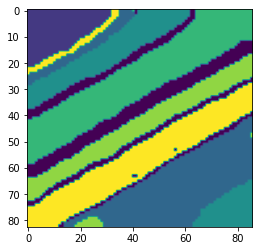

Accuracy using CVAE_V2: 71.55


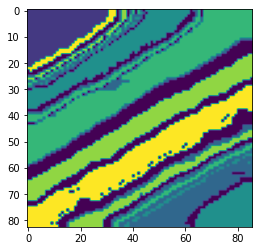

In [ ]:
#Run Laplace and Poisson learning
labels_raw = gl.graph_ssl(W_raw,train_ind,train_labels,algorithm='laplace')
labels_cvae = gl.graph_ssl(W_cvae,train_ind,train_labels,algorithm='laplace')
labels_cvae2 = gl.graph_ssl(W_cvae2,train_ind,train_labels,algorithm='laplace')

#Print accuracy
print('Using %d labels per class'%int(len(train_ind)/7))
print('Accuracy using raw pixel values: %.2f'%gl.accuracy(labels_raw,labels,len(train_ind)))
print('Accuracy using CVAE: %.2f'%gl.accuracy(labels_cvae,labels,len(train_ind)))

# Results
showCVAE = labels_cvae.reshape(83, 86)
plt.imshow(showCVAE)
plt.show(block = True)

print('Accuracy using CVAE_V2: %.2f'%gl.accuracy(labels_cvae2,labels,len(train_ind)))
showCVAE2 = labels_cvae2.reshape(83, 86)
plt.imshow(showCVAE2)
plt.show(block = True)